# Hola mundo... 
Agradecemos de manera especial a la PhD Lorena A. Barba [@LorenaABarba](https://twitter.com/LorenaABarba), quien desarrolló el material [CFDPython](https://github.com/barbagroup/CFDPython), sobre el cual está desarrollado el siguiente proyecto pedagógico.

¡Hola! Bienvenido a **Una introducción a la ecuación de Navier-Stokes en una y dos dimensiones, buscando soluciones numúricas vía Python**. Este es un material práctico que se utiliza al comienzo de un curso interactivo de dinámica de fluidos computacional (CFD), y está basado en la propuesta del curso **12 steps to Navier–Stokes**, el cual es impartido por el [Prof. Lorena Barba](http://lorenabarba.com) desde la primavera de 2009 en la Universidad de Boston.

El curso asume solo conocimientos básicos de programación y, por supuesto, algunos fundamentos en ecuaciones diferenciales parciales y mecánica de fluidosy se imparte en su totalidad utilizando Python.

# Ecuación de convección lineal

Para poder estudiar algunas ideas en la discretización de las ecuaciones de Navier-Stokes en una dimensión (1-D) y dos dimensiones (2-D) es importarte comenzar estudiando la ecuación de [convección lineal](http://www.unet.edu.ve/~fenomeno/F_DE_T-165.htm)

$$\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0.$$
con condiciones iniciales $u(x,0)=u_0(x)$, dato conocido como onda inicial. La ecuación representa la propagación de la onda inicial con velicidad $c$. La solución analítica usando variables separables es dada por $u(x,t)=u_0(x-ct)$.

Para poder implementar el método numérico, nosotros discretizamos esta ecuación tanto en el tiempo como en el espacio, usando el esquema de diferencias finitas hacia adelante para la derivada en el tiempo y el esquema de diferencias finitas hacia atrás para la derivada en el espacio.

La coordenada espacial $x$ se discretiza en $N$ pasos regulares $\Delta x$ desde $i=0$ hasta $i=N$. Para la variable temporal $t$ se discretiza tomando intervalos de tamaño $\Delta t$.
Por la definición de derivada, removiendo el límite, es posible aproximar

$$\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}.$$

Así, por nuestra discretización, se sigue que:
$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0, $$
donde $n$ y $n+1$ son dos pasos en el tiempo, mientras que $i-1$ y $i$ son dos puntos vecinos de la coodenada $x$ discretizada. Si se tienen en cuenta la condiciones iniciales, la única variable desconocida es $u_i^{n+1}$. Resolviendo la ecuación para $u_i^{n+1}$, podemos obtener una ecuación que nos permita avanzar en el tiempo de la siguiente manera: 
$$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n).$$


In [1]:
import numpy as np                    
import matplotlib.pyplot as plt 
import time, sys                   
%matplotlib inline
#esto hace que los gráficos de matplotlib aparezcan en el cuaderno (en lugar de una ventana separada)

## Ahora definamos algunas variables: 

queremos definir una cuadrícula de puntos uniformemente espaciados dentro de un dominio espacial que tiene $2$ unidades de longitud de ancho, es decir,  $x_i\in(0,2)$. Definiremos una variable `nx`, que será el número de puntos de cuadrícula que queremos y `dx` será la distancia entre cualquier par de puntos de cuadrícula adyacentes.

In [2]:
nx = 41  
dx = 2 / (nx-1)
nt = 20   #nt es el número de pasos de tiempo que queremos calcular
dt = .025  #dt es la cantidad de tiempo que cubre cada paso de tiempo (delta t)
c = 1     # suponga una velocidad de onda de c = 1

También necesitamos configurar nuestras condiciones iniciales.

Para ello, disponemos de dos funciones, definidas sobre el intervalo $(0,2)$. 
# Ejemplo 1: f1
La velocidad inicial $ u_0 $ se da como
$ u = 2 $ en el intervalo $ 0.5 \leq x \leq 1 $ y $ u = 1 $ en cualquier otro lugar de $ (0,2) $ (es decir, una función de sombrero). 

# Ejemplo 2: f2
Fijando el tiempo, y tomando valores fijos para las constastes, podemos crear un variado número de funciones para la velocidad inicial. 
$$u_n(x,t)=C_n\sin\left(\frac{n\pi c}{L}t+\phi_n\right) \sin\left(\frac{n\pi }{L}x\right)$$

In [3]:
def f1(nx):
    #dx = 2 / (nx-1)
    u = np.ones(nx)      #numpy función ones()
    u[int(.5 / dx):int(1 / dx + 1)] = 2  #configurar u = 2 entre 0.5 y 1 y u = 1 para todo lo demás según nuestra CI
    #print(u)
    return u

In [4]:
def f1_var(x):
    u=np.piecewise(x,[x<0.5,np.abs(x-0.75)<=0.25,x>1],[lambda x:1,lambda x: 2,lambda x:1])
    return u

In [5]:
def f2(nx):
    #dx = 2 / (nx-1)
    L=2
    n=4
    Fi=0.2#ángulo de fase temporal
    c=10 #velocidad de la onda
    A=0.5#amplitud máxima, relacionada con la intensidad del sonido
    t=0.18 #instantánea en el tiempo t segundos
    x=np.arange(0.0,L+dx,dx)
    u=A*np.sin(n*np.pi*c*0.005*t/L+Fi)*np.sin(n*np.pi*x/L)#aquí definimos la función
    return u

In [6]:
def mostrar_imagen(u):
    plt.plot(np.linspace(0, 2, nx), u);

## Ahora es el momento de implementar la discretización de la ecuación de convección utilizando un esquema de diferencias finitas.

Para cada elemento de nuestra matriz `u`, necesitamos realizar la operación $$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

Almacenaremos el resultado en una nueva matriz (temporal) `un`, que será la solución $ u $ para el próximo paso de tiempo. Repetiremos esta operación durante tantos pasos de tiempo como especifiquemos y luego podremos ver qué tan lejos se ha convectado la onda.

Primero inicializamos nuestra matriz de marcador de posición `un` para contener los valores que calculamos para el paso de tiempo $ n + 1 $, usando una vez más la función NumPy`ones() `.

Entonces, podemos pensar que tenemos dos operaciones iterativas: una en el espacio y otra en el tiempo (aprenderemos de manera diferente más adelante), por lo que comenzaremos anidando un bucle dentro del otro. Tenga en cuenta el uso de la ingeniosa función `range()`. Cuando escribimos: `for i in range(1, nx)` iteraremos a través de la matriz `u`, pero omitiremos el primer elemento (el elemento cero). *¿Por qué?*

In [7]:
def ECL(u):
    for n in range(nt):  # bucle para valores de n de 0 a nt, por lo que se ejecutará nt veces
        un = u.copy() ##copiar los valores existentes de u en un
        for i in range(1, nx): 
        #for i in range(nx): 
            u[i] = un[i] - c * (dt / dx) * (un[i] - un[i-1])
        #pyplot.plot(np.linspace(0, 2, nx), u);
    return u

In [ ]:
def ECLspeed(u):
    for n in range(nt): ## recorrer el número de pasos de tiempo
        un = u.copy()
        u[1:] = un[1:]- c * (dt / dx) * (un[1:] - un[:-1])
    return u

Usemos el método para la ECL con la función usada en el ejemplo 1, denominada `f1`.

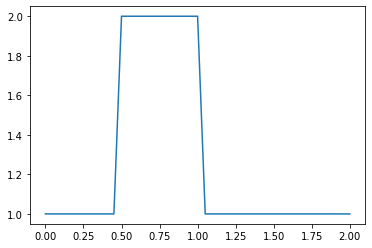

In [8]:
u=f1(nx)
mostrar_imagen(u)

Cuyo resultado final, después de $t = 0.5$ segundos es:

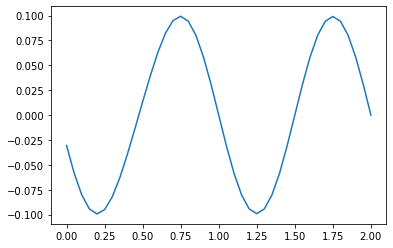

In [9]:
u=ECL(f2(nx))
mostrar_imagen(u)

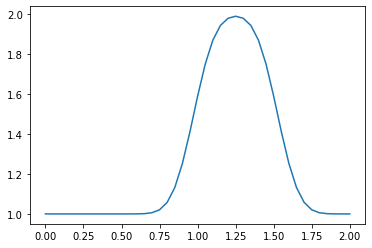

In [10]:
x=np.arange(0.0,2.0+dx,dx)
u=ECL(f1_var(x))
mostrar_imagen(u)

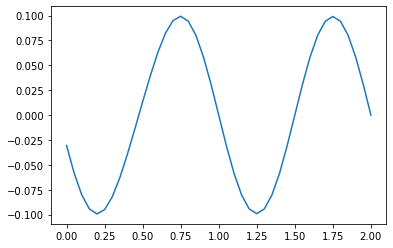

In [11]:
u=ECL(f2(nx))
mostrar_imagen(u)

# Ecuación de convección no lineal

Consideremos la ecuación de convección no lineal (ECnL) dada por 

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

Usaremos la misma discretización que en el caso lineal: diferencia hacia adelante en el tiempo y diferencia hacia atrás en el espacio. Aquí está la ecuación discretizada.

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + u_i^n \frac{u_i^n-u_{i-1}^n}{\Delta x} = 0.$$

Resolviendo en términos de $u_i^{n+1}$, obtenemos:

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n)$$

Para obtener una explicación más detallada del método de diferencias finitas, es necesario tocar temas como el error de truncamiento, el orden de convergencia y otros detalles, que por efectos de tiempo no vamos a tratar en este proyecto.
Aún así, el lector que quiera profundizar en esto, por favor vea las lecciones en video 2 y 3 de la profesora Barba en YouTube.

In [12]:
def ECnL(u):
    for n in range(nt):  # bucle para valores de n de 0 a nt, por lo que se ejecutará nt veces
        un = u.copy() ##copiar los valores existentes de u en un
        #for i in range(1, nx): 
        for i in range(nx): 
            u[i] = un[i] - un[i] * (dt / dx) * (un[i] - un[i-1])
        #print(u)
        #pyplot.plot(np.linspace(0, 2, nx), u);
    return u

## Juguemos un poco...

... con los valores de `nx` en la **ecuación lineal**

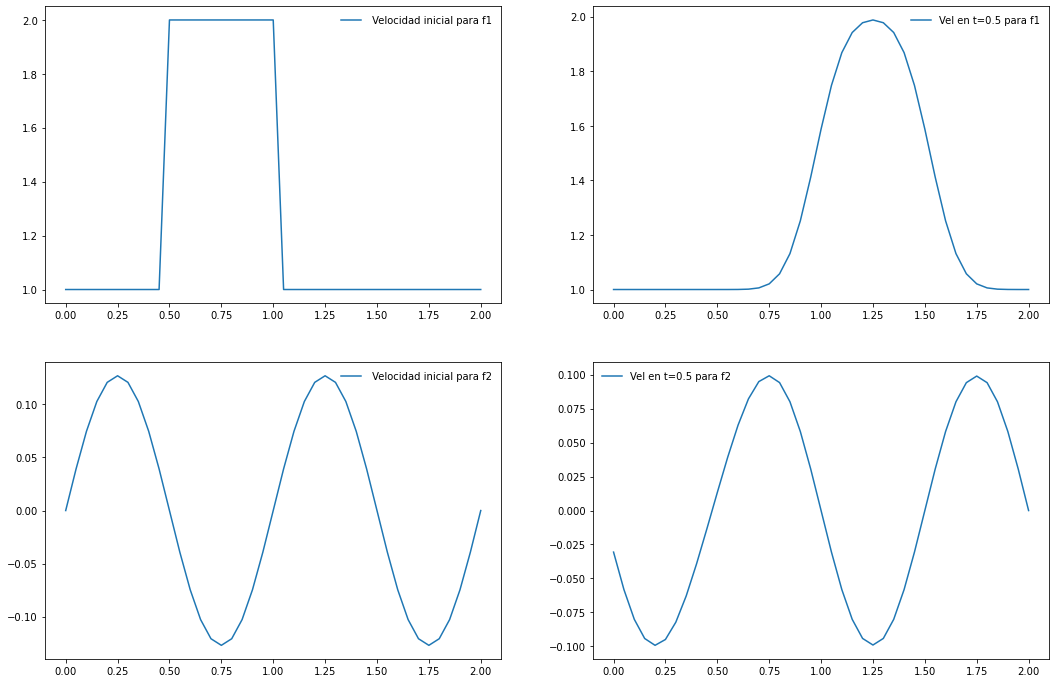

In [13]:
nx = 41 # intente cambiar este número de 41 a 81 y Ejecutar todo ... ¿qué sucede? 
dx = 2 / (nx-1)
nt = 20 #nt es el número de pasos de tiempo que queremos calcular
dt = .025  #dt es la cantidad de tiempo que cubre cada paso de tiempo (delta t)
c = 1     # suponga una velocidad de onda de c = 1
x=np.arange(0.0,2.0+dx,dx)

plt.figure(figsize=(18,12))
#como colocar un título general a un paquete 

plt.subplot(2, 2, 1) 
plt.plot(x,f1(nx),label=f' Velocidad inicial para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 2) 
plt.plot(x,ECL(f1(nx)),label=f'Vel en t=0.5 para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 3) 
plt.plot(x,f2(nx),label=f' Velocidad inicial para f2')
plt.legend(frameon=False)
plt.subplot(2, 2, 4) 
plt.plot(x,ECL(f2(nx)),label=f'Vel en t=0.5 para f2')
plt.legend(frameon=False)
plt.show()

## Y ahora,

en la **ecuación no lineal**...

# ¿Qué sucede?

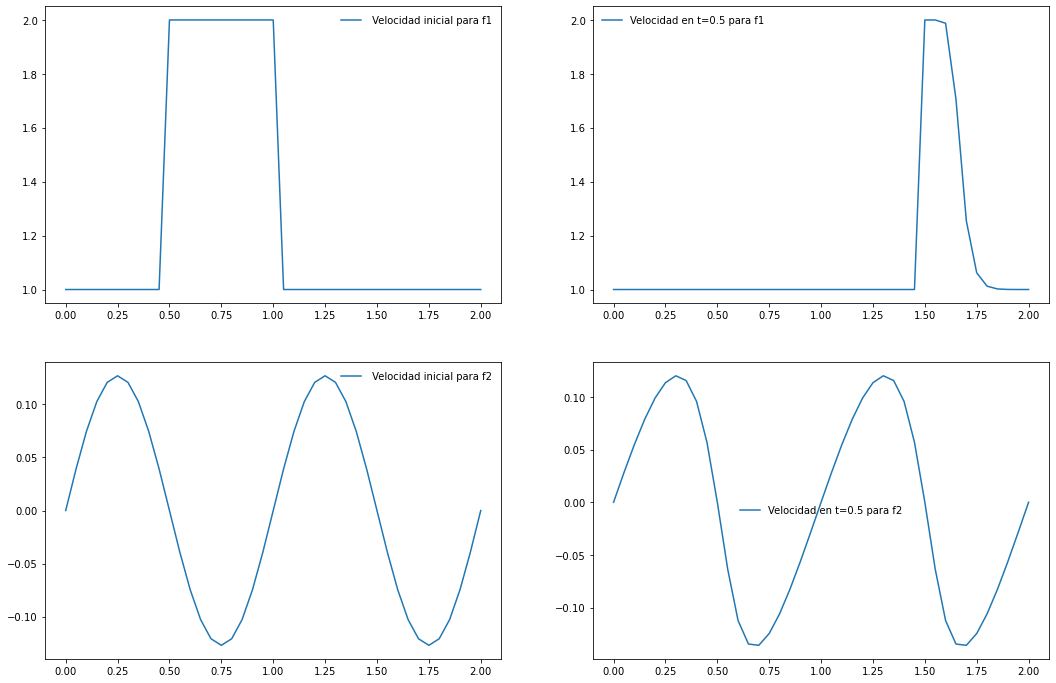

In [14]:
nx = 41 # intente cambiar este número de 41 a 81 y Ejecutar todo ... ¿qué sucede? 
dx = 2 / (nx-1)
nt = 20   #nt es el número de pasos de tiempo que queremos calcular
dt = .025  #dt es la cantidad de tiempo que cubre cada paso de tiempo (delta t)
c = 1     # suponga una velocidad de onda de c = 1
x=np.arange(0.0,2.0+dx,dx)

plt.figure(figsize=(18,12))
#como colocar un título general a un paquete 

plt.subplot(2, 2, 1) 
plt.plot(x,f1(nx),label=f' Velocidad inicial para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 2) 
plt.plot(x,ECnL(f1(nx)),label=f'Velocidad en t=0.5 para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 3) 
plt.plot(x,f2(nx),label=f' Velocidad inicial para f2')
plt.legend(frameon=False)
plt.subplot(2, 2, 4) 
plt.plot(x,ECnL(f2(nx)),label=f'Velocidad en t=0.5 para f2')
plt.legend(frameon=False)
plt.show()

Para responder a esa pregunta, tenemos que pensar un poco sobre lo que realmente estamos implementando en el código.

En cada iteración de nuestro ciclo de tiempo, usamos los datos existentes sobre nuestra onda para estimar la velocidad de la onda en el siguiente paso de tiempo. Inicialmente, el aumento en el número de puntos de la cuadrícula arrojó respuestas más precisas. Hubo menos difusión numérica y la onda cuadrada se parecía mucho más a una onda cuadrada que en nuestro primer ejemplo.

Cada iteración de nuestro ciclo de tiempo cubre un intervalo de tiempo de longitud $\Delta t $, que hemos estado definiendo como 0.025

Durante esta iteración, evaluamos la velocidad de la onda en cada uno de los puntos $ x $ que hemos creado. En la última trama, claramente algo salió mal.

Lo que ha sucedido es que durante el período de tiempo $ \Delta t $, la onda viaja una distancia que es mayor que `dx`. La longitud `dx` de cada cuadro de cuadrícula está relacionada con el número de puntos totales` nx`, por lo que la estabilidad se puede aplicar si el tamaño del paso $ \Delta t $ se calcula con respecto al tamaño de `dx`.

$$\sigma = \frac{u \Delta t}{\Delta x} \leq \sigma_{\max}$$


donde $ u $ es la velocidad de la onda; $ \sigma $ se llama [**número de Courant**](https://n9.cl/86phk) (CFL) y el valor de $\sigma_{\max} $ que garantizará la estabilidad depende de la discretización utilizada.


En una nueva versión de nuestro código, usaremos el número CFL para calcular el paso de tiempo apropiado `dt` dependiendo del tamaño de `dx`.

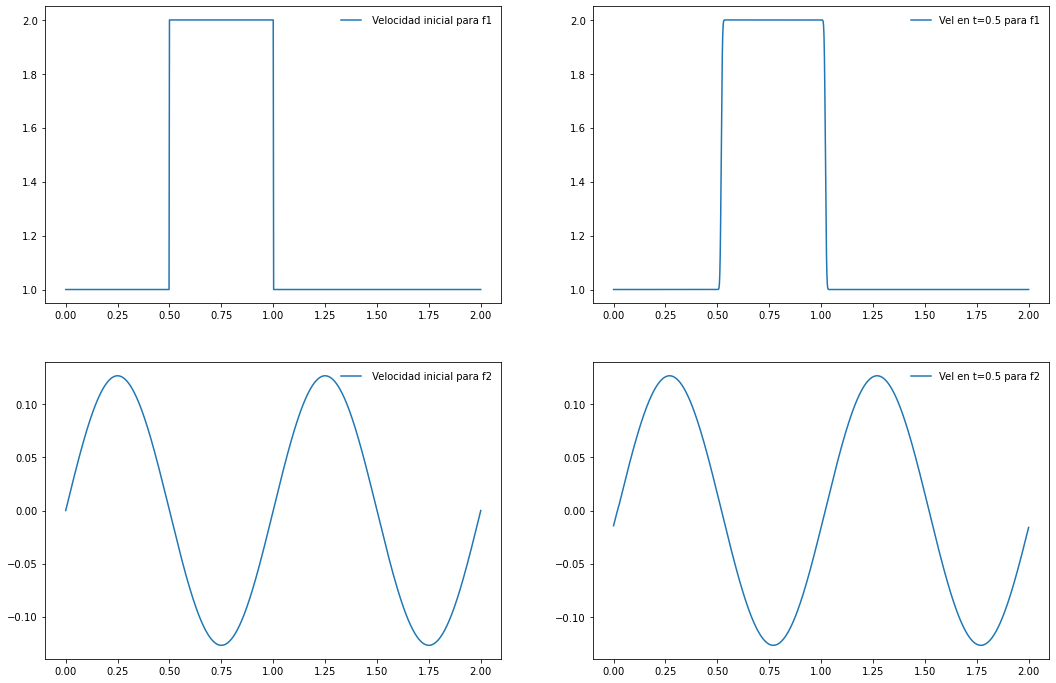

In [15]:
nx = 1001 # intente cambiar este número de 41 a 81 y Ejecutar todo ... ¿qué sucede? 
dx = 2 / (nx-1)
nt = 20   #nt es el número de pasos de tiempo que queremos calcular
sigma =0.5
dt = sigma * dx  #dt es la cantidad de tiempo que cubre cada paso de tiempo (delta t)
c = 1     # suponga una velocidad de onda de c = 1
x=np.arange(0.0,2.0+dx,dx)

plt.figure(figsize=(18,12))
#como colocar un título general a un paquete 

plt.subplot(2, 2, 1) 
plt.plot(x,f1(nx),label=f' Velocidad inicial para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 2) 
plt.plot(x,ECL(f1(nx)),label=f'Vel en t=0.5 para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 3) 
plt.plot(x,f2(nx),label=f' Velocidad inicial para f2')
plt.legend(frameon=False)
plt.subplot(2, 2, 4) 
plt.plot(x,ECL(f2(nx)),label=f'Vel en t=0.5 para f2')
plt.legend(frameon=False)
plt.show()

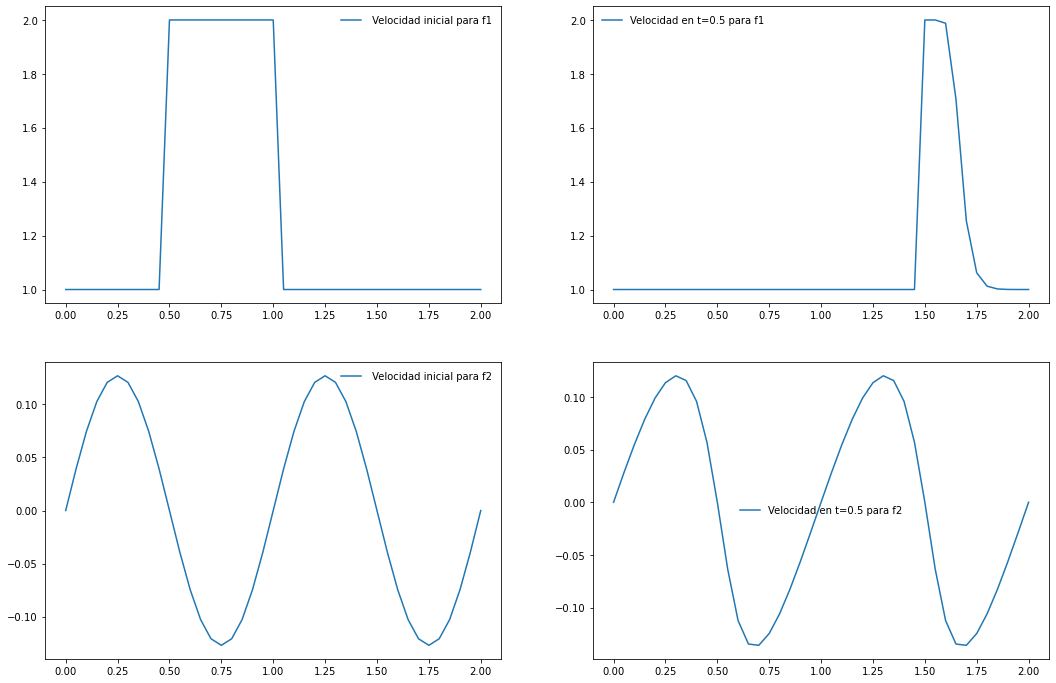

In [16]:
nx = 41 # intente cambiar este número de 41 a 81 y Ejecutar todo ... ¿qué sucede? 
dx = 2 / (nx-1)
nt = 20   #nt es el número de pasos de tiempo que queremos calcular
dt = .025  #dt es la cantidad de tiempo que cubre cada paso de tiempo (delta t)
c = 1     # suponga una velocidad de onda de c = 1
x=np.arange(0.0,2.0+dx,dx)

plt.figure(figsize=(18,12))
#como colocar un título general a un paquete 

plt.subplot(2, 2, 1) 
plt.plot(x,f1(nx),label=f' Velocidad inicial para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 2) 
plt.plot(x,ECnL(f1(nx)),label=f'Velocidad en t=0.5 para f1')
plt.legend(frameon=False)
plt.subplot(2, 2, 3) 
plt.plot(x,f2(nx),label=f' Velocidad inicial para f2')
plt.legend(frameon=False)
plt.subplot(2, 2, 4) 
plt.plot(x,ECnL(f2(nx)),label=f'Velocidad en t=0.5 para f2')
plt.legend(frameon=False)
plt.show()

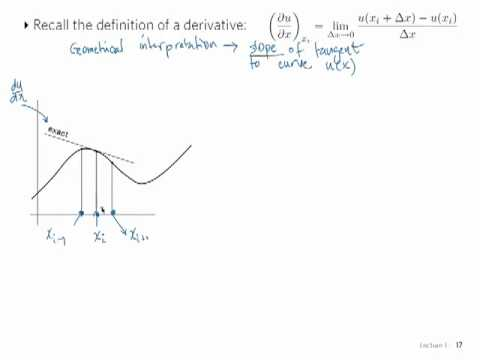

In [17]:
from IPython.display import YouTubeVideo
YouTubeVideo('iz22_37mMkk')

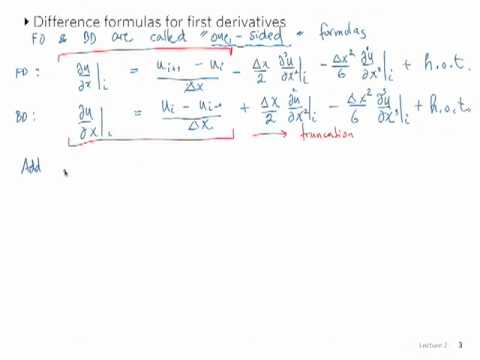

In [18]:
YouTubeVideo('xq9YTcv-fQg')

# Extra!!!
Para una descripción detallada de la discretización de la ecuación de convección lineal con diferencias finitas (y también los siguientes problemas estudiados aquí), vea la Lección en video 4 del Prof. Barba en YouTube.

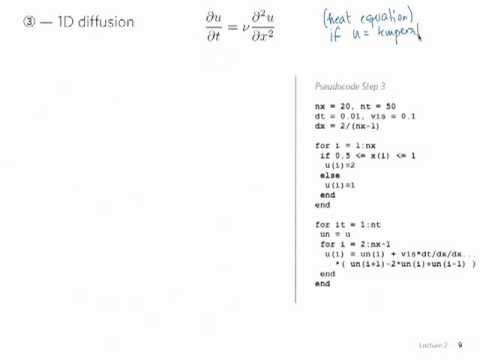

In [19]:
YouTubeVideo('y2WaK7_iMRI')